# Introduction

This notebook allows you to run a simplified version of the ANTARESS workflow, to process stellar disk-integrated (DI) profiles during an exoplanet transit with the following steps:
- aligning the profiles into the star rest frame
- scaling the profiles to their correct relative flux level
- extracting differential and intrinsic profiles
- computing intrinsic CCFs from spectral profiles

This notebook can take as input a time-series of DI echelle spectra (first cleaned with the [reduction notebook](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_sp_reduc.ipynb)) or CCFs (possibly generated with the [mock notebook](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_mock.ipynb)). A typical use of the intrinsic CCFs output by this notebook is to analyze the Rossiter-McLaughlin signal from the transiting planet, which can be done in a simplified way using the [RM notebook](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_RMR.ipynb).  

The default version of this notebook is set up to process the default mock dataset provided with ANTARESS. To try it out, copy the directory `Arda/` from `Notebooks/Mock_system/` into the directory of your choice (named, for example, `Working_dir/`) and set `working_path` to this directory location. Otherwise adjust the settings to retrieve your own cleaned dataset, setting `working_path`, `star_name`, and `pl_name` to the same values that you used to initialize your [observed](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_setup.ipynb) or [mock](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_setup_Arda.ipynb) system.

To exploit the workflow to its full capabilities, run its executable with the [configuration files](https://obswww.unige.ch/~bourriev/antaress/doc/html/installation.html).

In [1]:
import ANTARESS_nbook_bground
input_nbook = {
    'working_path' : '/Users/bourrier/Travaux/ANTARESS/Working_dir/',
    'star_name' : 'Arda',
    'pl_name' : 'Valinor'
}
input_nbook=ANTARESS_nbook_bground.load_nbook(input_nbook, 'Processing')

# Processing

**Systemic velocity**

Run this cell to set the systemic rv `gamma` (float, in km/s) to the value specific to your visit. `gamma` can vary slightly with the epoch and the instrument, and should thus be derived from each dataset itself rather than set to an external value.

Ideally, you should have measured `gamma` using the [DI CCF analysis notebook](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_detrending.ipynb)). If you are using the present notebook with DI CCFs directly, you can also set `gamma` = 0 km/s and [run directly](#Launch_ANTARESS) the workflow. The systemic rv will be printed in ANTARESS log as the weighted mean of the out-of-transit DI CCFs centroids.

In [2]:
input_nbook['par']['gamma'] = 10.
ANTARESS_nbook_bground.set_sysvel(input_nbook)
ANTARESS_nbook_bground.ana_prof(input_nbook,'DI')

**Alignment in star rest frame**

Run this cell to align the DI profiles in the star rest frame. Profiles input into the workflow are typically defined in the Sun barycentric rest frame. Here, they are Doppler-shifted by the systemic rv defined above, and by the Keplerian rv motion induced by all planets you set up for this system.

In [3]:
ANTARESS_nbook_bground.align_prof(input_nbook)

**Flux scaling**

Run this cell to scale the DI profiles to their correct relative flux level over the transit. The scaling depends on the limb-darkening coefficients and planet-to-star radius ratio that you set up for the system.

In [4]:
ANTARESS_nbook_bground.flux_sc(input_nbook)
ANTARESS_nbook_bground.DImast_weight(input_nbook)

**Differential profile extraction**

Run this cell to extract differential profiles, which are the difference between the master DI out-of-transit profile (representative of the unocculted star) and the DI profiles in each exposure. During transit, differential profiles correspond to the light coming from the planet-occulted regions of the stellar photosphere. 

In [5]:
ANTARESS_nbook_bground.extract_diff(input_nbook)

At this stage, you can define further processing steps below, or you can [run directly](#Launch_ANTARESS) ANTARESS and retrieve the time-series of differential profiles (stored under `/Working_dir/Star/Planet_Saved_data/Diff_data/instrument_night_i.npz`) to fit them outside of the workflow with an atmospheric code like [EvE](https://gitlab.unige.ch/spice_dune/eve/)).

**Intrinsic profile extraction**

Run this cell to convert in-transit residual profiles into intrinsic profiles, which are corrected for broadband planetary absorption and stellar intensity variations, and only trace variations in the spectral profile of stellar lines along the transit chord. Use the full workflow to mask narrow absorption lines from the planetary atmosphere, if relevant. 

In [6]:
ANTARESS_nbook_bground.extract_intr(input_nbook)

At this stage, you can define further processing steps below, or you can [run directly](#Launch_ANTARESS) ANTARESS to generate the intrinsic profiles series (stored under `/Working_dir/Star/Planet_Saved_data/Diff_data/instrument_night_i.npz`, where `i` refers to in-transit indexes). They can be used to characterize spatial variations of the stellar photosphere (rv motions, spectral lines, ...) along the transit chord, using the full workflow or external tools. 

# Converting intrinsic spectra into CCFs


**This step is only relevant if you are processing spectra**

Run this cell to cross-correlate intrinsic spectra with a chosen mask. You need to define:

+ `start_RV` (float): lower boundary of the CCF RV grid (in km/s), relative to the systemic velocity
+ `end_RV` (float): upper boundary of the CCF RV grid (in km/s), relative to the systemic velocity
+ `dRV` (float): step size of the CCF RV grid (in km/s). Set to `None` to use instrumental resolution
+ `mask_path` (string): path (relative to `'working_path'`) + name of the mask file
+ `calc_CCF` (bool): set to `False` to retrieve the CCFs and not calculate them again

As an example, we provide the [CCF mask](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ESPRESSO_new_G9.fits) used by the ESPRESSO DRS for G9-type stars. You can use it to process the TOI-421 dataset provided with ANTARESS [reduction notebook](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_sp_reduc.ipynb).

In [7]:
input_nbook['par'].update({
    'start_RV' : -150.,
    'end_RV'   :  150.,
    'dRV'      : None,
    'mask_path': '/ESPRESSO_new_G9.fits',
    'calc_CCF' : True,
})
ANTARESS_nbook_bground.conv_CCF(input_nbook,'Intr')

Run the next cell to save the system settings, in case you want to further process your dataset with notebooks.

In [8]:
ANTARESS_nbook_bground.save_system(input_nbook)

Initialized system stored in :  /Users/bourrier/Travaux/ANTARESS/Working_dir/Arda/Valinor_Saved_data


# Plot settings

The following cells allow you to set up the [plot display](#Plot_display) of your dataset.

Define the index of the spectrograph order to be plotted (**only relevant with spectra**).
Adjust `x_range` to the rv or wavelength range of the profiles.

In [9]:
input_nbook['par']['x_range'] = [-31.,31.]
input_nbook['par']['iord2plot'] = 113

**Differential profiles**

Run this cell to plot the phase vs rv map of differential profiles.

Adjust `v_range` to the flux range of the dataset (corresponding to the map color scale), or set to `None` for automatic determination.

In [10]:
input_nbook['par']['v_range'] = [-1e3,26e3] 
ANTARESS_nbook_bground.plot_map(input_nbook,'Diff_prof')

**Intrinsic profiles**

Run this cell to plot the time-series and phase vs rv map of intrinsic profiles.

Use `y_range` and `v_range` to adjust the flux range of the dataset (vertical axis in 1D, color scale in 2D), or set to `None` for automatic determination.

In [11]:
input_nbook['par']['y_range'] = [0.4,1.1]
ANTARESS_nbook_bground.plot_prof(input_nbook,'Intr_prof')
input_nbook['par']['v_range'] = [0.4,1.1]
ANTARESS_nbook_bground.plot_map(input_nbook,'Intr_prof')

<a id='Launch_ANTARESS'></a>
# Running ANTARESS

In [12]:
from antaress.ANTARESS_launch.ANTARESS_launcher import ANTARESS_launcher
ANTARESS_launcher(working_path=input_nbook['working_path'], nbook_dic = input_nbook, exec_comm=False)

****************************************
Launching ANTARESS
****************************************

Multi-threading: 16 threads available
Running with artificial data
Covariances discounted
Study of: Valinor
Accounting for Keplerian motion from all planets
Automatic definition of T14[Valinor]=2.99 h
Default nsub_Dpl[Valinor]=124

-----------------------
Processing instrument : ESPRESSO
-----------------------
  Reading and initializing CCFs
   > Data resampled on a common spectral table
         Retrieving data
         Processing visit mockvis
           All exposures share a common spectral table
           50 exposures
  -----------------
  Processing visit: mockvis
  -----------------
   > 50 exposures
         26 in-transit
         24 out-of-transit (12 pre / 12 post)
   > Calculating properties of planet-occulted regions
         Calculating data
   > Analyzing disk-integrated stellar profiles
         Calculating data
         Systemic rv from time-series = 0.124448 +- 1.4095

<a id='Plot_display'></a>
# Plot display

In [13]:
from IPython.display import Image
from IPython.core.display import HTML 

Run the cells below to show saved plots.

**Differential profile map**

This plot shows the series of differential profiles in phase vs RV or wavelength space, colored with flux. 
Outside of the transit window (marked by the dashed white lines) the profiles should trace white noise around zero, if the stellar photosphere remained stable during the visit.
Within the transit window, profiles vary in flux due to the broadband planetary occultation and stellar intensity variations, and show bright tracks following the planet-occulted stellar lines.

The mock system used as default for this notebook is aligned, which is why the occulted track is symmetrical and goes from negative to positive rv following the rotational motion of the photosphere along the transit chord. 

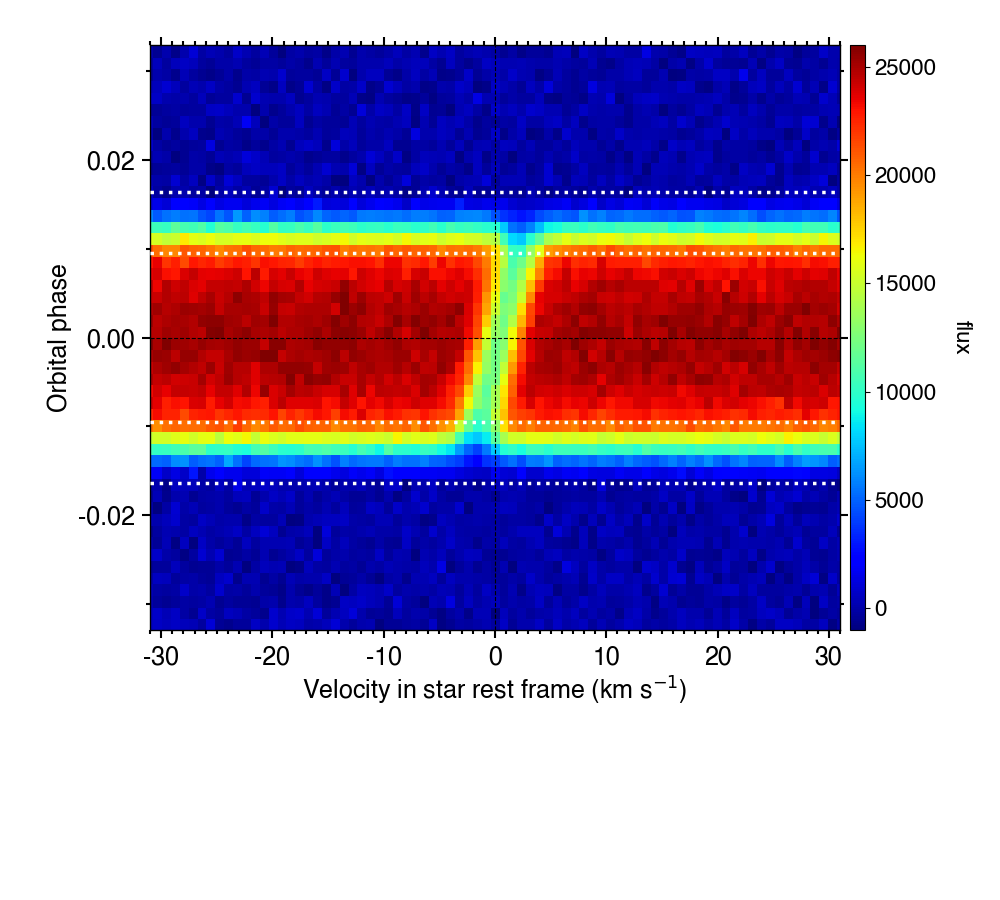

In [14]:
Image(filename = input_nbook['plot_path']+'Diff_data/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'_Map/Data/'+input_nbook['par']['type']+'/iord'+str(input_nbook['par']['iord2plot'])+'.png')

**Intrinsic profile series**

This plot shows the time-series of intrinsic profiles, as the planet moves along the transit chord. 

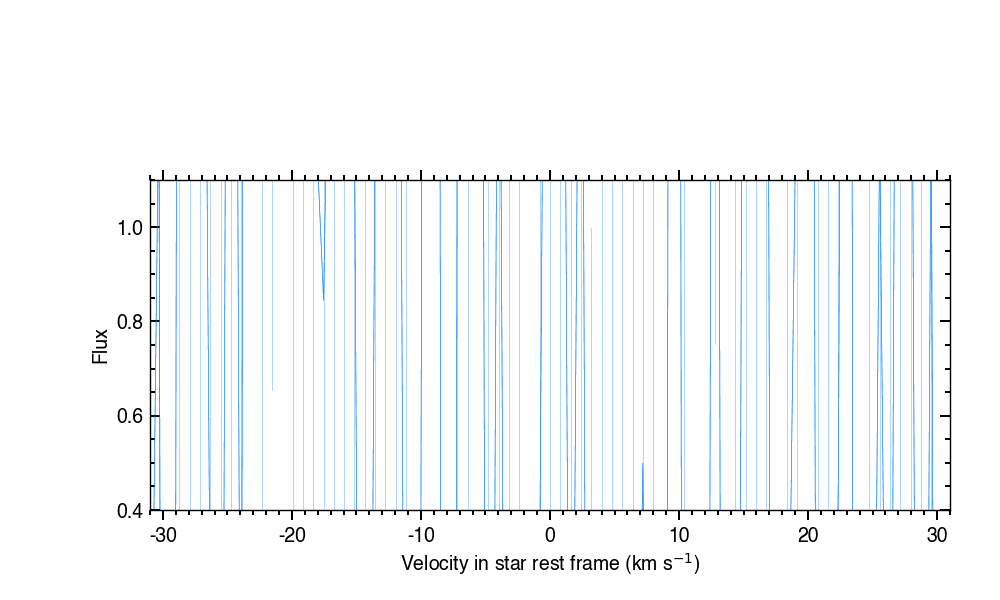

In [15]:
Image(filename = input_nbook['plot_path']+'Intr_data/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'_Indiv/Data/'+input_nbook['par']['type']+'/phase.gif')

**Intrinsic profile map**

This plot shows the series of intrinsic profiles in phase vs RV or wavelength space, colored with flux. 
Intrinsic profiles are corrected for broadband flux variations and only trace variations in the occulted stellar lines.
The green solid track (for plots in CCF format) is the photospheric rv model for the sky-projected stellar rotational velocity (`vsini`) and spin-orbit angle (`lambda`) that you used to set-up the system.

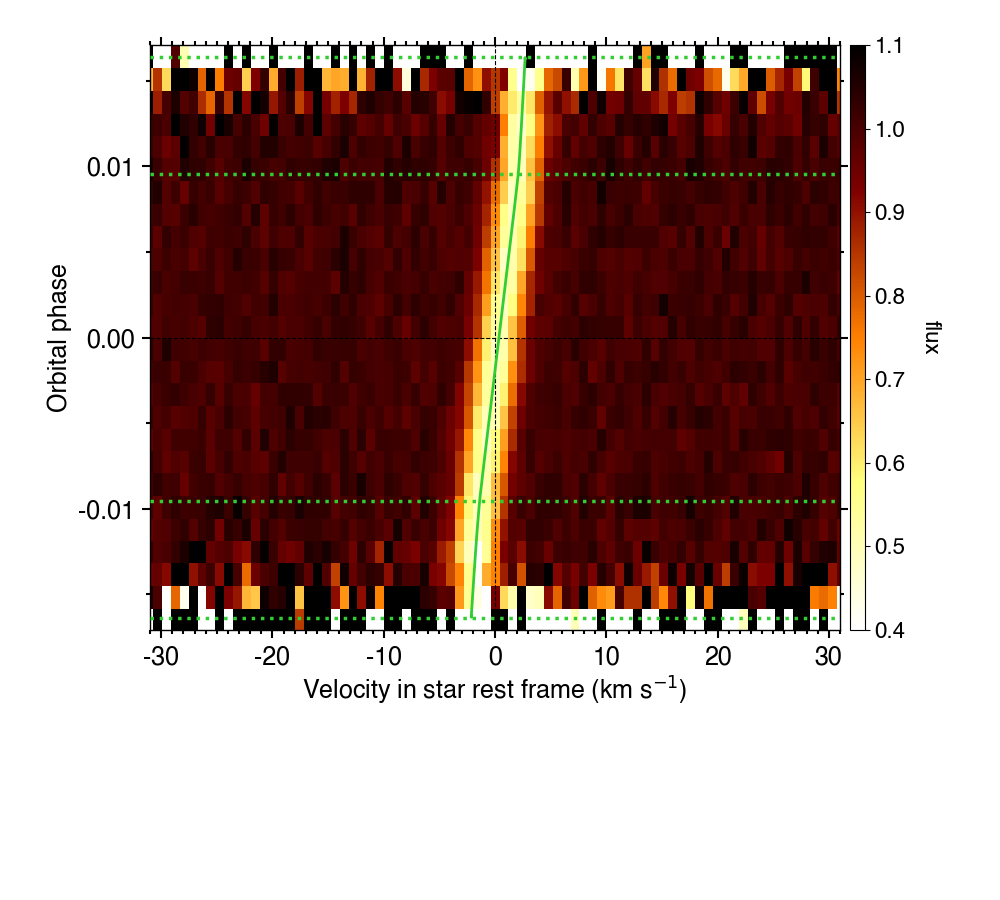

In [16]:
Image(filename = input_nbook['plot_path']+'Intr_data/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'_Map/Data/'+input_nbook['par']['type']+'/iord'+str(input_nbook['par']['iord2plot'])+'.png')